In [1]:
import torch

dataset = "marson" #"sciplex", "L008"
dimension = 8
threshold = 0.2

dict = torch.load("../artifact/saves/graph-inference-marson_2023.03.01_02:16:23/model_seed=0_epoch=230.pt")
#dict = torch.load("../artifact/saves/graph-inference-sciplex_2022.08.13_00:23:35/model_seed=0_epoch=230.pt")
#dict = torch.load("../artifact/saves/graph-inference-L008_2022.09.12_18:55:13/model_seed=0_epoch=230.pt")

In [2]:
edge_weight = torch.sigmoid(dict[0]["edge_weight_logits"]).cpu().t()
edge_weight

tensor([[0.1824, 0.1639, 0.1577,  ..., 0.1600, 0.1599, 0.1600],
        [0.1571, 0.1165, 0.1593,  ..., 0.1595, 0.1810, 0.1600],
        [0.1596, 0.1613, 0.1377,  ..., 0.1520, 0.1602, 0.1603],
        ...,
        [0.1517, 0.1640, 0.1612,  ..., 0.9999, 0.1708, 0.1462],
        [0.1600, 0.1599, 0.1589,  ..., 0.1597, 0.1456, 0.1623],
        [0.1599, 0.1607, 0.1600,  ..., 0.1599, 0.1567, 0.1570]])

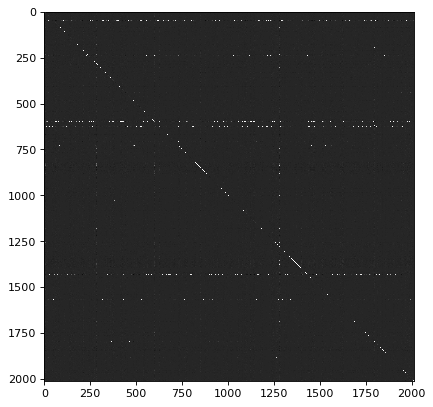

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.imshow(edge_weight, cmap='gray', interpolation='nearest')
plt.show()

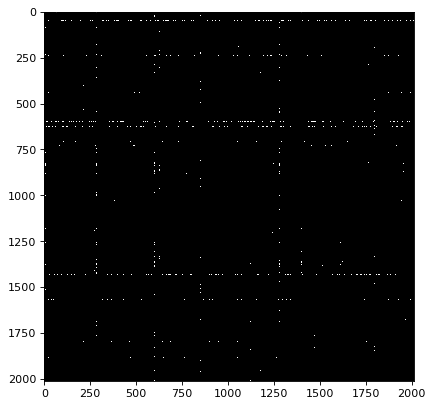

In [4]:
edge_weight_discrete = edge_weight - torch.eye(len(edge_weight))
edge_weight_discrete = edge_weight_discrete.apply_(lambda x: x>threshold)

figure(figsize=(8, 6), dpi=80)
plt.imshow(edge_weight_discrete, cmap='gray', interpolation='nearest')
plt.show()

In [5]:
grn = torch.load("%s_grn_%s.pth" % (dataset, dimension))
grn

Data(x=[2013, 8], edge_index=[2, 42563])

In [6]:
import sys, os
module_paths = [os.path.abspath('.'), os.path.abspath('..')]
for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)

from torch_geometric.utils import to_dense_adj
edge_index = to_dense_adj(grn.edge_index)[0]
edge_index

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

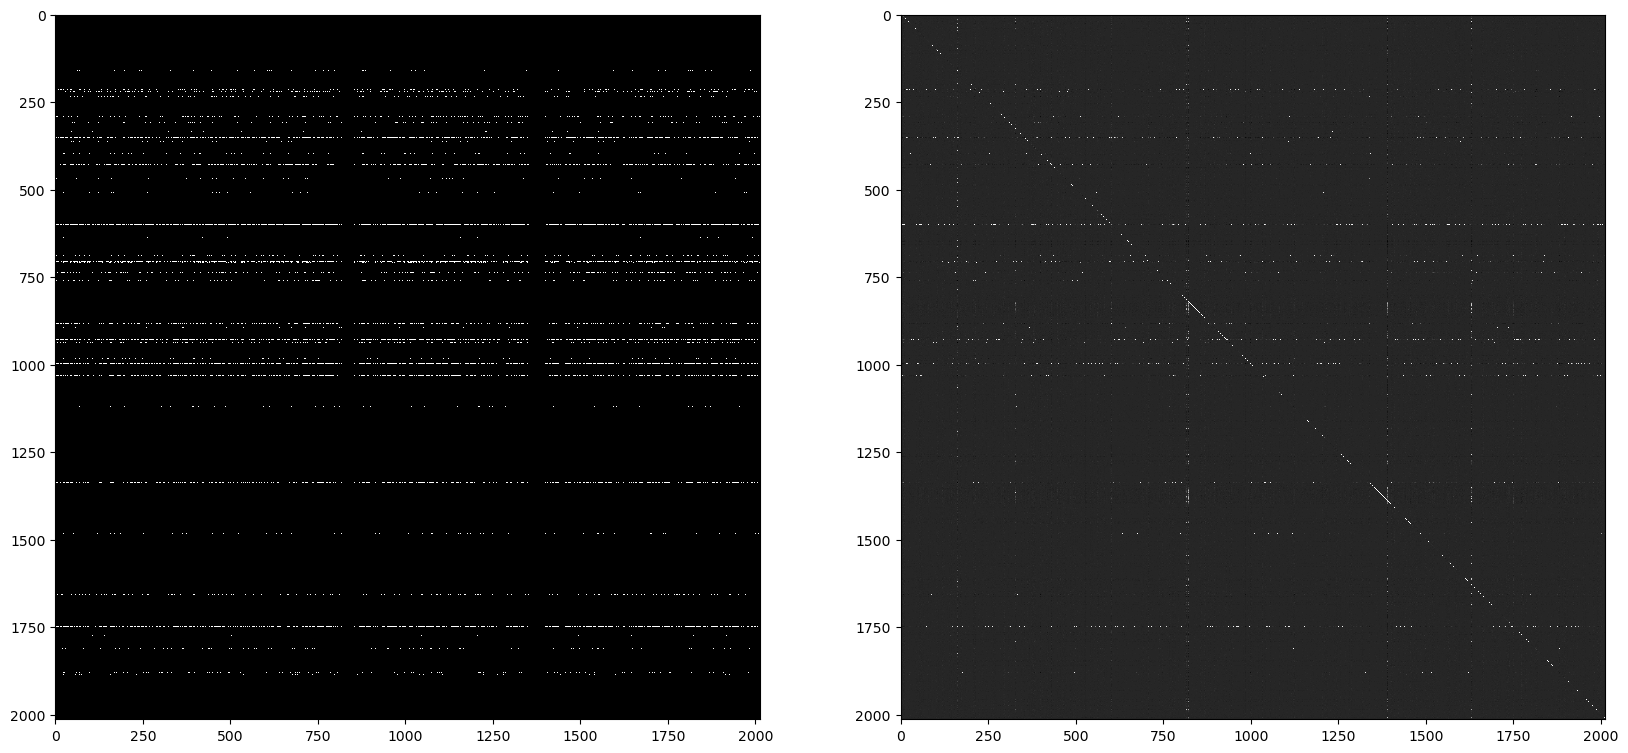

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 10, forward=True)
fig.set_dpi(100)

ax1.imshow(edge_index, cmap='gray', interpolation='nearest')
ax2.imshow(edge_weight, cmap='gray', interpolation='nearest')

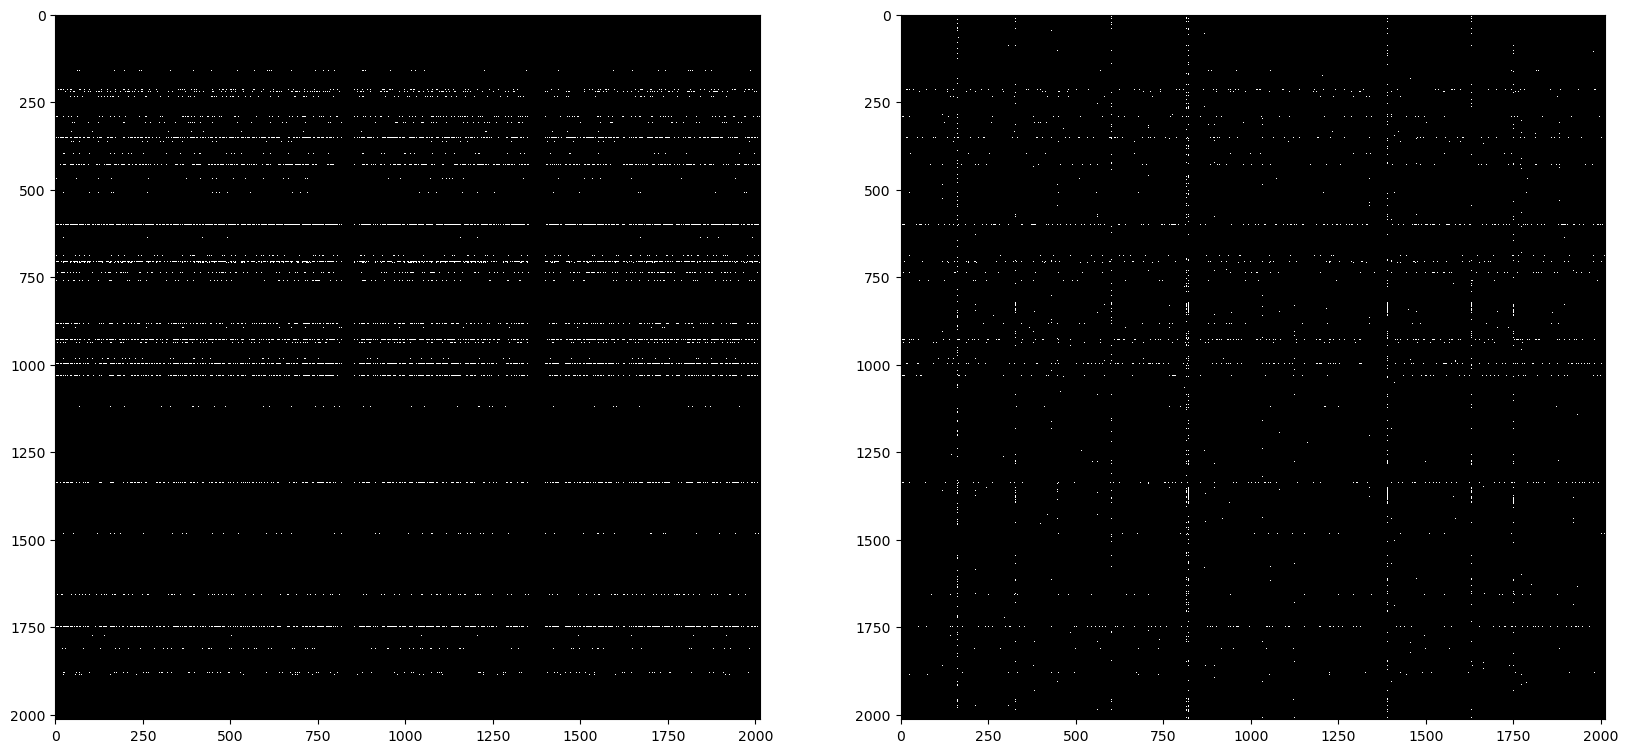

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 10, forward=True)
fig.set_dpi(100)

ax1.imshow(edge_index, cmap='gray', interpolation='nearest')
ax2.imshow(edge_weight_discrete, cmap='gray', interpolation='nearest')

In [9]:
import numpy as np
gene_names = np.genfromtxt('./node/source/%s/genes.txt' % dataset, dtype='str')
gene_names

array(['ISG15', 'TNFRSF18', 'TNFRSF4', ..., 'KDM5D', 'TTTY10', 'EIF1AY'],
      dtype='<U12')

In [10]:
import pandas as pd
pd.DataFrame(
    data=edge_weight, index=gene_names, columns=gene_names
).to_csv("%s_updated_grn.csv" % dataset, index_label='gene_short_name')

pd.DataFrame(
    data=edge_weight_discrete, index=gene_names, columns=gene_names
).to_csv("%s_updated_grn_filtered.csv" % dataset, index_label='gene_short_name')

In [11]:
import networkx as nx

def parse_grn(grn_df, name_col) -> nx.Graph:
    '''Parse a GRN data frame to a graph.
    Assumes the file has targets as rows and sources as columns
    '''
    # build graph
    graph = nx.DiGraph()
    for _, row in grn_df.iterrows():
        target_gene = row[name_col]
        edges = [(src_gene, target_gene) for src_gene in row[row==1].index]
        graph.add_edges_from(edges)
    return graph

In [12]:
import pickle
graph_df = pd.read_csv('%s_updated_grn_filtered.csv' % dataset)
nx_graph = parse_grn(graph_df, 'gene_short_name')

pickle.dump(nx_graph, open('./%s_grn.pkl' % dataset, 'wb'))